# Hyperparameter tuning

To improve the performance of our model, we need to delve into the realm of hyperparameter tuning. Hyperparameters are settings that we can adjust to optimize the behavior and accuracy of our machine learning model, to fine-tune it's performance. 

The previous model was trained with certain default hyperparameter values, which serve as a baseline. However, these default values may not always yield the best results for our specific problem.

Hyperparameter tuning involves systematically exploring different combinations of hyperparameter values to find the optimal configuration that maximizes our model's performance. This process is often iterative and involves training and evaluating the model multiple times with different hyperparameter settings.

In [ ]:
import sys
sys.path.insert(0, './src')
import utils



import albumentations as A
import os
import torch
import torch.nn as nn
import warnings
import torch.utils.data as data
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning) # Masks are not georeferences, so we can ignore this warning
warnings.filterwarnings("ignore", category=UserWarning) # This will throw a warning message about cudnn, this is normal (https://github.com/pytorch/pytorch/pull/125790)

In [9]:
# MEAN = [63.02235933, 66.64201154, 60.63862196]
# STD = [55.50368184, 55.35826425, 52.63471437]
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
MAX_LR = 1e-4
TRAIN_SIZE = 320
VAL_SIZE = 360
NUM_WORKERS = 4
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 4
EPOCHS = 80
LOAD_BEST = True
NAME = "6 - LR1e-4 TrainBatch8 Epoch80 Resize - NoAugmentation"

DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
DATA_PATH = OUTPUT_PATH + "data/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"

We'll reimport the default values that we had from before

We slightly modified the values of the transformations! We're having a better alignment, and using A.RandomCrop is better than A.Resize because you don't loose details

In [ ]:
device = utils.set_cuda_and_seed()

print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())


train_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.CenterCrop(896, 896),
    A.RandomCrop(TRAIN_SIZE, TRAIN_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

eval_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.RandomCrop(896, 896),
    A.Resize(VAL_SIZE, VAL_SIZE)
])
from dataset import SN6Dataset

train_dataset = SN6Dataset(DATASET_PATH, transform=train_transforms, split='train')
eval_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='val')
test_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='test')

train_loader = data.DataLoader(train_dataset, pin_memory = True, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
eval_loader = data.DataLoader(eval_dataset, pin_memory = True, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = data.DataLoader(test_dataset, pin_memory = True, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

image, mask = next(iter(train_loader))
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
utils.visualize_image(image[0], mask[0])

We'll be trying something new: A custom loss function that connects both BCEWithLogitLoss and a custom-made Dice loss (since we already established it's our best parameter) in a 50/50 mix. It's been implemented in _custom_loss.py_

we'll try to work on 
 - Normalization
 - A better Segmentation
 - Maybe slowing down the learning rate even further
 

In [ ]:
from model import UNET

model = UNET(in_channels = 3, out_channels = 1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=MAX_LR, weight_decay=1e-5)

# We won't use a scheduler at first, but we'll add it later
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS)
scaler = torch.cuda.amp.GradScaler()


One of the things I've noticed in the training is how hard it's for the model to track small buildings, this is because to make our batch_size higher a downscale was necessary; we modified some values, changing:
 - SIZE to 300x300
 - BATCH_SIZE to 8

In [ ]:
from train import train

best_f1 = 0.0
history = {
    'train_loss': [],
    'val_loss': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': [],
    'last_epoch': 0 
}

last_epoch = 0
if LOAD_BEST:
    print("Restoring best model")
    if(os.path.exists(CHECKPOINT_PATH + f"best_{NAME}.pth")):
        history = utils.load_checkpoint(CHECKPOINT_PATH + f"best_{NAME}.pth", model, optimizer, scheduler)
        best_f1 = max(history['f1'])
        last_epoch = history['last_epoch']
        print(f"Best model found, starting from epoch {last_epoch+1} with f1_score {best_f1}")
    else:
        print("Best model not found, starting from scratch")

# Training model
for epoch in range(last_epoch, EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_loss = train(train_loader, model, optimizer, criterion, scaler, scheduler, device)
    # Detect if loss is NaN, and immediately stop with a ValueError 
    
    
    eval_loss, precision, recall, f1, accuracy = utils.get_evals(eval_loader, model, criterion, device, save_predictions=True, output_path=DATA_PATH)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(eval_loss)
    history['precision'].append(precision)
    history['recall'].append(recall)
    history['f1'].append(f1)
    history['accuracy'].append(accuracy)
    history['last_epoch'] = epoch
    print(f"Train loss: {train_loss:.4f} Eval loss: {eval_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f} Accuracy: {accuracy:.4f}")
    # Save model
    checkpoint = {
        "history" : history,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": criterion.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + f"checkpoint_{NAME}.pth")
    if f1 > best_f1:
        best_f1 = f1
        utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + f"best_{NAME}.pth")
        print("Best model saved")

    if epoch - 5 > 0: # Value of validation loss is increasing, model is overfitting. Need to stop training
        if history['val_loss'][epoch] > history['val_loss'][epoch-1] > history['val_loss'][epoch-2] > history['val_loss'][epoch-3] > history['val_loss'][epoch-4]:
            print("Early stopping")
            break
print("Finished training! Well done :3\nQuitting...")

loading checkpoint


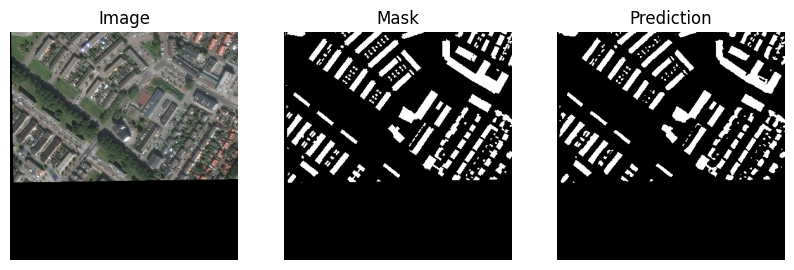

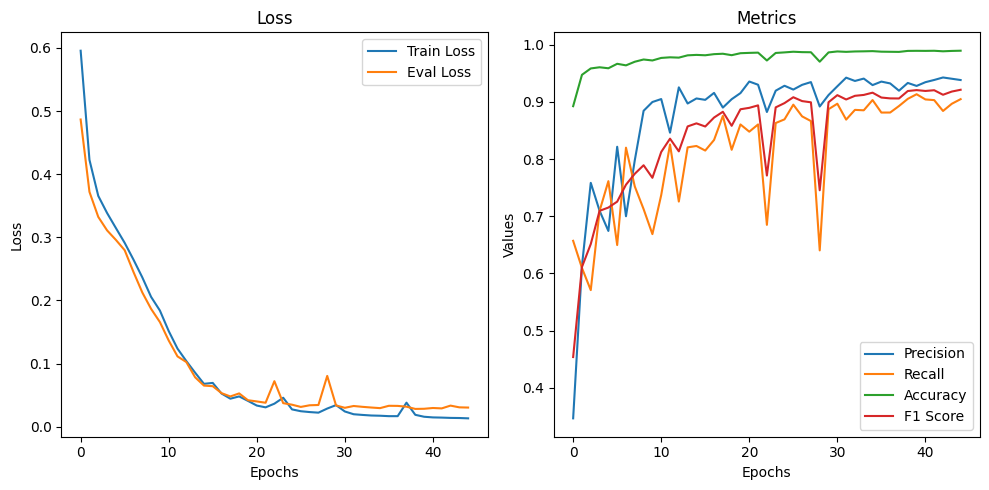

In [10]:
import matplotlib.pyplot as plt

# Get the history
history = utils.load_checkpoint(CHECKPOINT_PATH + f"checkpoint_{NAME}.pth", model)
image, mask, pred = utils.get_random_image(eval_loader, model, device)
utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = GRAPH_PATH + f"image_{NAME}.png")

train_loss = history['train_loss']
eval_loss = history['val_loss']
precision = history['precision']
recall = history['recall']
accuracy = history['accuracy']
f1_score = history['f1']
# Plot the loss and other metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(accuracy, label='Accuracy')
plt.plot(f1_score, label='F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig(GRAPH_PATH + f"metrics_{NAME}.png")
plt.show()